# Gaussian Mixture Model

Consider a set of data containing a mixture of $K$ 1d-gaussians with different $\mu_k$ and $\sigma_k$. Each $\mu_k$ follows some normal distribution with some variance and denote $c_i$ as the particular gaussian that the i-th particle comes from. 
Mathematically, 

\begin{gather*}
\mu_k \sim \mathcal{N}(0, s^2) \\
c_i \sim Categorical(1/K, \cdots) \\
x_i|\mathbf{\mu}, c_i \sim \mathcal{N}(\mathbf{c}^T\mathbf{\mu}, \mathbf{\sigma})
\end{gather*}

Let's visualize the data.

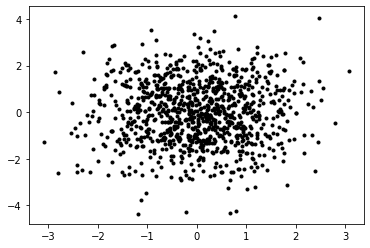

In [34]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


class gaussian_mixture_model_1d:
    def __init__(self):
        self.mixtures = dict()
        self.samples = dict()

    def add_gaussian(self, mean, sigma):
        model = stats.multivariate_normal(mean, cov=sigma)
        self.mixtures[(mean,sigma)] = model
    
    def sample(self, sizes):
        sizes = list(sizes)
        while len(sizes) < len(self.mixtures):
            sizes.append(sizes[-1])
        for i, (key, model) in enumerate(self.mixtures):
            self.sample[key] = self.model.rvs(size = sizes[i])

    def plot_samples(self, ax=None, sizes=[100], **kwargs):
        if ax is None:
            ax = plt.gca()
        
        kw = dict(
            fmt = 'k.',
        )
        kw.update(kwargs)
        data = self.sample(sample_size=sample_size)
        x, y= data.T
        ax.errorbar(x, y, **kw)

class gaussian_model_2d:
    def __init__(self, mean=[0,0], cov=[[1,0],[0,2]]):
        self.model = stats.multivariate_normal(mean, cov)

    def sample(self, sample_size):
        return self.model.rvs(size=sample_size)

    def plot_pdf(self, ax=None, range=[(-1,1), (-1,1)], interval=(0.01,0.01), **kwargs):
        x = np.arange(*range[0], interval[0])
        y = np.arange(*range[1], interval[1])
        xx, yy = np.meshgrid(x, y, indexing='ij')
        zz = np.dstack((xx, yy))
         
        kw = dict(
            cmap = 'jet',
        )
        kw.update(kwargs)
        if ax is None:
            ax = plt.gca()
        ax.contourf(xx, yy, self.model.pdf(zz), **kw)

    def plot_sample(self, ax=None, sample_size=1, **kwargs):
        if ax is None:
            ax = plt.gca()
        
        kw = dict(
            fmt = 'k.',
        )
        kw.update(kwargs)
        data = self.sample(sample_size=sample_size)
        x, y= data.T
        ax.errorbar(x, y, **kw)
